In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from datetime import datetime, date
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
FILES_DIR = './files/'
events = pd.read_csv(FILES_DIR + 'sampled_events.csv')
product = pd.read_csv(FILES_DIR + 'sampled_products.csv')
users = pd.read_csv(FILES_DIR + 'sampled_users.csv')

# Data-Pre-processing

In [3]:
events_df = events.copy()
events_df

,session_id,event_timestamp,event_name,user_no,item_no,device_type,mobile_brand_name,mobile_model_name,mobile_marketing_name,operating_system_version,country,region,platform
0,c47e93742387750baba2e238558fa12d,2021-06-03 13:00:01.845,click_item,+9eODQMZ8YgXQZJJAo56nw==,4KwsZkXDulM0oQ2sTVSlYQ==,mobile,Samsung,SM-N960N,Galaxy Note9,Android 10,South Korea,Gyeonggi-do,ANDROID
1,f482aba7e1b76564c5404d96650f0dbd,2021-06-03 13:00:01.920001,add_to_cart,qik2Oa/1SQAjHeR64GLY0g==,+3vED/NUxtVk4Dvc0QUahA==,mobile,Samsung,SM-G977N,Galaxy S10 5G,Android 11,South Korea,Seoul,ANDROID
2,9af56dc40a6586dd211ca30f0a3e74d1,2021-06-03 13:00:02.35,click_item,FJJ6W70VNARaqflivNavLg==,xuuGT7/l+fld/geUzu6BkA==,mobile,Apple,iPhone,NaN,iOS 14.4.2,South Korea,Seoul,IOS
3,51e148afe55e6f296c0931cac6bc2c1d,2021-06-03 13:00:02.994,click_item,MsFi+mS5EhwSv+ZqTtZ53w==,FC0aiDVh1JjIXUschc44Pg==,mobile,Apple,iPhone,NaN,iOS 14.4.2,South Korea,Gyeongsangbuk-do,IOS
4,3316370366bdbd2fdff02e996c1b2721,2021-06-03 13:00:03.312001,add_to_cart,frWHEf/czsCEjklEIwxxKA==,yXpbzgtgRe37PEbJlBiKmQ==,mobile,Samsung,SM-G970N,Galaxy S10e,Android 11,South Korea,Seoul,ANDROID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880402,dd2a71d30af7c856b61223bd45b54dbe,2021-08-04 12:59:53.129054,click_item,ROKDMwVDKbb9N82CptJ9dg==,xKvqk3vRvFLpCTQTqpL4ew==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Gyeongsangnam-do,IOS
5880403,1006525137f948b588322af3ffe4f7ec,2021-08-04 12:59:56.151,click_item,0nfvwBd9Qriig0lIgvtiBA==,1qWgJ5SJvbi5+mBYGH848A==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Gyeongsangnam-do,IOS
5880404,5ca46d4d8ffc29bad42d8b6fc830e364,2021-08-04 12:59:56.952028,click_item,Z0a8cvN+t0V2WInGzjkM5Q==,M9ucsQ4dNX/t1Bopo599BA==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Gyeonggi-do,IOS
5880405,184c25447f47b4c831a9771801381577,2021-08-04 12:59:58.019142,click_item,vQeO3FiA+W7bmyu2tdKuGg==,W/LoA3I9ym6wowhAdCsUvA==,mobile,Samsung,SM-G977N,Galaxy S10 5G,Android 11,South Korea,Busan,ANDROID


In [4]:
events_df.isnull().sum()

session_id                        0
event_timestamp                   0
event_name                        0
user_no                           0
item_no                           0
device_type                       0
mobile_brand_name              3594
mobile_model_name              3594
mobile_marketing_name       4250941
operating_system_version          0
country                          12
region                         2195
platform                          0
dtype: int64

In [5]:
# events_df.user_no.nunique()
# 유저수 254958
# events_df.event_name.unique()
# ['click_item', 'add_to_cart', 'purchase_success', 'like_item']
# events_df.device_type.unique()
# 모바일과 태플릿만 있다. 데스크탑은 없다
# events_df.session_id.nunique()
# 1425915
# 세션아이디와 유저는 다르다

In [6]:
# 리소스 문제로 29402 데이터만 사용
# duplicated 하는 이유는 log데이터 특성상 
events_sample = events_df.sample(frac=0.005, random_state=42)
events_sample

,session_id,event_timestamp,event_name,user_no,item_no,device_type,mobile_brand_name,mobile_model_name,mobile_marketing_name,operating_system_version,country,region,platform
1916969,434cf67167c5becc6321d03bdecd6c60,2021-06-24 09:25:17.097027,click_item,qwTrxFylir2ynPu9N7/g/w==,/ZasVJSuvWNKGQXzKT0uCg==,mobile,Apple,iPhone,NaN,iOS 14.4.2,South Korea,Seoul,IOS
4178142,23288f3e8d799799645beb4bff6c35ad,2021-07-16 22:38:19.169111,click_item,OXbjPQaxKL7O8HoSMzJtiQ==,/YlZZk+EM3eAaLCGdgyiag==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Seoul,IOS
644115,dc7c3da68a67b1f43a2226ea2733bebf,2021-06-09 23:25:54.245213,click_item,1jhscZ7MrX7w6sojiWm8cw==,TByIyj8aQeeoE2OnGWr4NQ==,mobile,Samsung,SM-N981N,Galaxy Note20 5G,Android 11,South Korea,Seoul,ANDROID
2047331,19422b436106a1cbc45bbe12bc59d11a,2021-06-25 22:37:42.032078,click_item,6+Uf31nW96b3VC61EfO4SQ==,F+25W5Hy9tVYnBlffA2Cmw==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Chungcheongnam-do,IOS
2679735,1a963aba0fb154be005ab97ddbf780aa,2021-07-02 08:51:53.27311,click_item,Zfy9Vola1OIOtuunlXev+A==,VoEeDect6p+wMXMoE5zAkw==,mobile,Samsung,SM-G965N,Galaxy S9+,Android 10,South Korea,Seoul,ANDROID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594921,4b2b5f6db5589fa7f736b0bd31f87685,2021-06-09 14:33:30.903094,click_item,3df2n7oVw8oZ3MuLxK5KYg==,GD6DtsasqVJamffP55apQA==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Gyeonggi-do,IOS
1256645,288d50850a8b0e43f2f2e6226a33e53a,2021-06-17 08:53:13.703111,click_item,2d9zQSt+DExdfvP/mj3Juw==,OCVwIGJhWNYNIwAxdI/Lag==,mobile,Samsung,SM-G977N,Galaxy S10 5G,Android 11,South Korea,Seoul,ANDROID
4173205,95cdce3d28de536e37dc837cedb58f21,2021-07-16 21:55:49.05804,add_to_cart,fxAptePuBEdVPekHLnmFnw==,mAznRa3p9hv4rhWkunWMFQ==,mobile,Samsung,SM-N960N,Galaxy Note9,Android 10,South Korea,Gyeonggi-do,ANDROID
3952661,5efe98cef53495a0ccec290e57e367fa,2021-07-14 17:17:28.635075,click_item,0h0lKPYrJcPeQlwIjKRohg==,tKZFh9pXCjI7VKLT3Pt1tw==,mobile,Apple,iPhone,NaN,iOS 14.6,South Korea,Jeollabuk-do,IOS


In [7]:
# 의미없는 컬럼 삭제 및 null값 처리
drop_events = events_sample.copy()
drop_events['mobile_brand_name'].fillna('un_brand_name', inplace=True)
drop_events.drop('mobile_marketing_name', axis=1, inplace=True)
drop_events.drop('mobile_model_name', axis=1, inplace=True)
drop_events.drop('operating_system_version', axis=1, inplace=True)
drop_events['rating'] = drop_events['event_name']
re_name = {'rating' : {'click_item':1, 'like_item':2, 'add_to_cart':3, 'purchase_success':4}}
drop_events = drop_events.replace(re_name)
drop_events.dropna(axis=0, inplace=True)
df_events = drop_events.copy()
df_events

,session_id,event_timestamp,event_name,user_no,item_no,device_type,mobile_brand_name,country,region,platform,rating
1916969,434cf67167c5becc6321d03bdecd6c60,2021-06-24 09:25:17.097027,click_item,qwTrxFylir2ynPu9N7/g/w==,/ZasVJSuvWNKGQXzKT0uCg==,mobile,Apple,South Korea,Seoul,IOS,1
4178142,23288f3e8d799799645beb4bff6c35ad,2021-07-16 22:38:19.169111,click_item,OXbjPQaxKL7O8HoSMzJtiQ==,/YlZZk+EM3eAaLCGdgyiag==,mobile,Apple,South Korea,Seoul,IOS,1
644115,dc7c3da68a67b1f43a2226ea2733bebf,2021-06-09 23:25:54.245213,click_item,1jhscZ7MrX7w6sojiWm8cw==,TByIyj8aQeeoE2OnGWr4NQ==,mobile,Samsung,South Korea,Seoul,ANDROID,1
2047331,19422b436106a1cbc45bbe12bc59d11a,2021-06-25 22:37:42.032078,click_item,6+Uf31nW96b3VC61EfO4SQ==,F+25W5Hy9tVYnBlffA2Cmw==,mobile,Apple,South Korea,Chungcheongnam-do,IOS,1
2679735,1a963aba0fb154be005ab97ddbf780aa,2021-07-02 08:51:53.27311,click_item,Zfy9Vola1OIOtuunlXev+A==,VoEeDect6p+wMXMoE5zAkw==,mobile,Samsung,South Korea,Seoul,ANDROID,1
...,...,...,...,...,...,...,...,...,...,...,...
594921,4b2b5f6db5589fa7f736b0bd31f87685,2021-06-09 14:33:30.903094,click_item,3df2n7oVw8oZ3MuLxK5KYg==,GD6DtsasqVJamffP55apQA==,mobile,Apple,South Korea,Gyeonggi-do,IOS,1
1256645,288d50850a8b0e43f2f2e6226a33e53a,2021-06-17 08:53:13.703111,click_item,2d9zQSt+DExdfvP/mj3Juw==,OCVwIGJhWNYNIwAxdI/Lag==,mobile,Samsung,South Korea,Seoul,ANDROID,1
4173205,95cdce3d28de536e37dc837cedb58f21,2021-07-16 21:55:49.05804,add_to_cart,fxAptePuBEdVPekHLnmFnw==,mAznRa3p9hv4rhWkunWMFQ==,mobile,Samsung,South Korea,Gyeonggi-do,ANDROID,3
3952661,5efe98cef53495a0ccec290e57e367fa,2021-07-14 17:17:28.635075,click_item,0h0lKPYrJcPeQlwIjKRohg==,tKZFh9pXCjI7VKLT3Pt1tw==,mobile,Apple,South Korea,Jeollabuk-do,IOS,1


In [8]:
print(df_events.isnull().sum().sort_values(ascending=False))

session_id           0
event_timestamp      0
event_name           0
user_no              0
item_no              0
device_type          0
mobile_brand_name    0
country              0
region               0
platform             0
rating               0
dtype: int64


In [9]:
grouped = df_events.groupby('item_no')
grouped['session_id'].count().sort_values(ascending=False)

item_no
Q0FgPI5gYPwi7sDRXYc2MA==    45
DtHkPrsjQWgkOUbVUaqbug==    44
upl3JSBbPyfbBCdzGXbyEw==    32
ZaLANVgSFf9opvMKO9zgLw==    29
f4eCC27uv5KkL4VhuUtesg==    20
                            ..
M514ctZRfEoi5pxfe1V7sg==     1
M6DJfOMXVGe7/FhfOPTHYw==     1
M6EXmptbb3f1s4tLaPCp+w==     1
M6FMJKPyLZMvftS/h1b5gQ==     1
zzueKk7tJ4RNaP/n1fN8dw==     1
Name: session_id, Length: 19726, dtype: int64

(array([1.9356e+04, 2.8000e+02, 6.4000e+01, 1.7000e+01, 5.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <BarContainer object of 10 artists>)

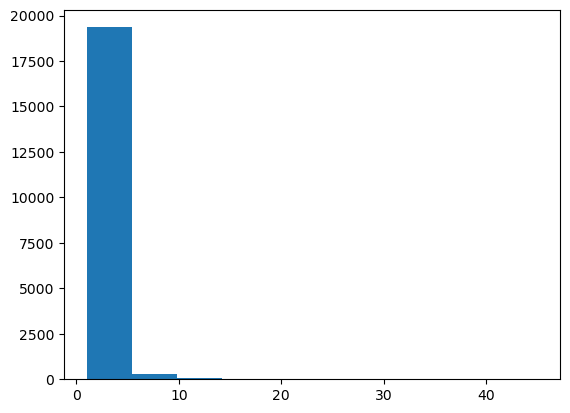

In [10]:
user_no_hist = grouped['session_id'].count()
plt.hist(user_no_hist)

In [12]:
today = pd.Timestamp.now().floor('D')
users['birth_date'] = pd.to_datetime(users['birth_date'], errors='coerce')
users = users[~pd.isnull(users['birth_date'])] # remove rows with missing birth date
users['age'] = ((today - users['birth_date']).dt.days / 365.25).astype(int)

def age_category(age):
    age = (age // 10) * 10
    return age

users['age'] = users.age.apply(age_category)

In [13]:
total_df = pd.merge(df_events, users)
total_df = pd.merge(total_df, product)
total_df['birth_date'].fillna('un_birth_date', inplace=True)
total_df['gender'].fillna('un_gender', inplace=True)
total_df.isnull().sum()

session_id           0
event_timestamp      0
event_name           0
user_no              0
item_no              0
device_type          0
mobile_brand_name    0
country              0
region               0
platform             0
rating               0
birth_date           0
gender               0
age                  0
item_name            0
category1_code       0
category2_code       0
category3_code       0
dtype: int64

In [14]:
total_df

,session_id,event_timestamp,event_name,user_no,item_no,device_type,mobile_brand_name,country,region,platform,rating,birth_date,gender,age,item_name,category1_code,category2_code,category3_code
0,434cf67167c5becc6321d03bdecd6c60,2021-06-24 09:25:17.097027,click_item,qwTrxFylir2ynPu9N7/g/w==,/ZasVJSuvWNKGQXzKT0uCg==,mobile,Apple,South Korea,Seoul,IOS,1,1988-02-24,F,30,[단독특가] 블루필 미니 휴대용 손선풍기 미니헤드 팬 프로 MINIHEAD FAN PRO,246100100,246107100,246107103
1,537a08c2a0d3dd1947e49c4e4ae5d4b1,2021-07-25 22:28:46.611102,click_item,x/587p+wg3ZYjjwjd11bLQ==,/ZasVJSuvWNKGQXzKT0uCg==,mobile,Apple,South Korea,Jeollabuk-do,IOS,1,1994-03-05,M,20,[단독특가] 블루필 미니 휴대용 손선풍기 미니헤드 팬 프로 MINIHEAD FAN PRO,246100100,246107100,246107103
2,23288f3e8d799799645beb4bff6c35ad,2021-07-16 22:38:19.169111,click_item,OXbjPQaxKL7O8HoSMzJtiQ==,/YlZZk+EM3eAaLCGdgyiag==,mobile,Apple,South Korea,Seoul,IOS,1,1978-02-15,F,40,VOLUME SHIRRING DRESS NAVY-DOT,243100100,243103100,243103101
3,83201f3514ee54af86b4e6840c7ba936,2021-07-24 20:45:08.007041,click_item,ChcjnsOuquHP0qarK/4E8g==,/YlZZk+EM3eAaLCGdgyiag==,mobile,Apple,South Korea,Ulsan,IOS,1,1992-11-26,F,30,VOLUME SHIRRING DRESS NAVY-DOT,243100100,243103100,243103101
4,eb5d2cd98f20aeef191dc00b36266ecb,2021-07-23 21:22:22.161097,click_item,OXbjPQaxKL7O8HoSMzJtiQ==,+lvKQMAiIgPVGQgr4OJ9ZA==,mobile,Apple,South Korea,Seoul,IOS,1,1978-02-15,F,40,retro stripe t-shirt (navy),243100100,243102100,243102103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27704,5f8879010fd0bbc65e33767a4c50ce90,2021-06-19 17:58:02.61925,click_item,ScXGdOTpSwrrtyqTJrL3WA==,i5QYgi8F6t7HY1OHKh0yDA==,mobile,Apple,South Korea,Ulsan,IOS,1,1989-03-12,F,30,[4차 재입고] Double Pocket Banding Shorts_Black,243100100,243104100,243104101
27705,711c8622048f9dfb3b881c3e4c6c6e5b,2021-07-04 04:44:01.904292,click_item,g/IGTetRKDNG2Ws4CrikrQ==,PVnZYvBWEztM3zyFnRPb/Q==,mobile,Apple,South Korea,Seoul,IOS,1,1987-02-15,F,30,"디밍 LED A60 White (전구색, E26)",246100100,246104100,246104118
27706,7e5cb3eda9e21ea8f18df3bb807363a0,2021-06-23 22:56:27.01846,click_item,DVISKj6SAySAidtg0Lh+YQ==,pDF+XMh3a3DMSVclhM2Cew==,mobile,Apple,South Korea,Gyeongsangnam-do,IOS,1,1988-01-10,M,30,WAREHOUSE BALL CAP (BLACK),244100100,244108100,244108102
27707,860d44258c03c48131df5aa0d753cb8c,2021-07-14 01:09:54.794106,click_item,za1J6wLU3SLbtfg6kqK0tQ==,wnXFvhkYdm9z2B4TigaP3g==,mobile,Apple,South Korea,Busan,IOS,1,1995-03-03,un_gender,20,김동완작가_fog series (M) B,248100100,248111100,248111107


# 베스트셀러 추천하기

In [15]:
def recom_item(item):
    return total_df.loc[product_mean.sort_values(by='rating', ascending=False)[:item].index]['item_name']
#     return best_seller.loc[product_mean.sort_values(ascending=False)[:item].index]['item_name']
product_mean = total_df.groupby(['item_no'])['rating'].mean()
product_mean = product_mean.reset_index()
recom_item(5)

11326                           크링클 우디 팬츠 (Musky Black)
15392              플라워 나눔 플레이트 3color / 만두접시 찬기 초밥 소스접시
9638     MARITHE X DIAGONAL WAVY BUTTON T-SHIRT (white)
4334          SALT-WATER SANDAL ADULT CLASSIC SLIDE TAN
9639     MARITHE X DIAGONAL WAVY BUTTON T-SHIRT (white)
Name: item_name, dtype: object

In [16]:
# train, test split
x = total_df.copy()
y = total_df['user_no']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

x_train.drop_duplicates(subset=['user_no', 'item_no'], inplace=True)


def RMSE(y_true, y_pred):
  return np.sqrt(np.mean(np.power(np.array(y_true)-np.array(y_pred), 2)))

def score(model):
  id_pairs = zip(x_test['user_no'], x_test['item_no'])
  y_pred = np.array([model(user, item) for (user, item) in id_pairs])
  y_true = np.array(x_test['rating'])
  return RMSE(y_true, y_pred)



rating_matrix = x_train.pivot(index='user_no', columns='item_no', values='rating')

In [17]:
def best_seller(user_no, item_no):
  try:
    rating = train_mean[item_no]
  except KeyError:
    rating = 3.0
  return rating

train_mean = x_train.groupby(['item_no'])['rating'].mean()
print('best-seller 방식의 정확도:', score(best_seller))

best-seller 방식의 정확도: 1.5922381271607986


# TF-IDF

In [18]:
cat_product = product.copy()

cat_product['cat'] = cat_product['category1_name'] + " " + cat_product['category2_name']
cat_product['cat'] = cat_product['cat'] + " " + cat_product['category3_name']
cat_product

,item_no,item_name,image_name,price,category1_code,category1_name,category2_code,category2_name,category3_code,category3_name,brand_no,brand_name,cat
0,++/211gtgspgB1TaPWEUQw==,베스트 코트\n( Vest Coat )_lavender,6842e3f320ef4459fac54dcea70c8245,1150000.0,243100100,의류,243101100,아우터,243101103,코트,4308.0,FOCEPS,의류 아우터 코트
1,++4eWFkX4oCtVYiKi34/Dw==,21SS 넥 페이스 패치 기모 맨투맨 블랙 CI0062 AHJ,1bdc06804580fddfbe46d4e2af140f08,466830.0,243100100,의류,243102100,상의,243102103,티셔츠,9302.0,Acne Studios_바이스트,의류 상의 티셔츠
2,++BoE+rYvLTJEAXMQFQLpQ==,[서울웰컴티 선물 세트] 일상 옥수수차,cb4a9bb103f9bd84d5d126ad4acec74b,15000.0,249100100,식품,249105100,음료,249105105,차류,4775.0,Urbanbookshop,식품 음료 차류
3,++RIzj1vpFLWgoX7LgCfLQ==,PLAIN SQUARE BAG S (IV),4c3f75e886c8114d7d00d19a4f0c34d5,118000.0,244100100,잡화,244102100,가방,244102104,토트백,2546.0,zisoo,잡화 가방 토트백
4,++W7/YMlPMwbAfyyJZEuIw==,클리어 바디미스트 150ml,5f136d4e25c837c3b658de16ac2156d9,27000.0,247100100,화장품/미용,247109100,바디케어,247109104,바디미스트,12986.0,밀크바오밥,화장품/미용 바디케어 바디미스트
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283321,zznjWkK64Fsflp1BbqeXQA==,SUMMER WOOL DOLMAN SLEEVE KNIT CARDIGAN,6e4bac52c12f2b2b923404c926fe404f,145000.0,243100100,의류,243102100,상의,243102102,카디건,14321.0,Carriere,의류 상의 카디건
283322,zzq8OW9uW0wofJhaKzp/Fg==,Silket Cotton Jersey T-Shirt Grey,569af51a0a61f7156b34b5cf251b82f0,98000.0,243100100,의류,243102100,상의,243102103,티셔츠,2085.0,aheit,의류 상의 티셔츠
283323,zzxE9xkXnKM0B4Y+hev34w==,[본사직영] 골라클래식 남성 COASTER HIGH (WHITE) GC_MA205_WW,3ca49f5d240325423bdc90942e2d61c5,75000.0,244100100,잡화,244101100,신발,244101115,스니커즈,4440.0,GOLA,잡화 신발 스니커즈
283324,zzzTNW8escss3zrnpuGMhQ==,21SS 마몬트 퀄팅 숄더/크로스백 448065 DTD1T 1000,00acf5906a360209ea248ae8933a2408,1743300.0,244100100,잡화,244102100,가방,244102103,크로스백,9410.0,GUCCI_바이스트,잡화 가방 크로스백


In [19]:
cat_product = cat_product.sample(frac=0.05, random_state=42)
cat_product = cat_product.drop_duplicates()
cat_product = cat_product.dropna()
cat_product['cat'] = cat_product['cat'].fillna('')

tfidf = TfidfVectorizer(stop_words='english') 
tfidf_matrix = tfidf.fit_transform(cat_product['cat'])

In [20]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim = pd.DataFrame(cosine_sim, index=cat_product.index, columns=cat_product.index)

In [21]:
indices = pd.Series(cat_product.index, index=cat_product['item_name'])
indices

item_name
Stream Dress_Sky                                                195722
UNISEX CUT-OFF DT LOGO SWEATSHORTS LIGHT MGREY_M_UDPA1E111G1      8322
당일발송)와이쓰리 GT5256 유틸리티 로고 스윔팬츠                                     3745
라탄 타원 미니 바구니 / 오발 트레이 정리함 인테리어 소품                               122497
버켄스탁 키즈 아리조나 일렉트릭 메탈릭실버 1019147                                 109624
                                                                 ...  
내열유리 머그잔1P 430ml (M-01)                                         184816
Modern Square Chain Bracelet                                    276474
Reversible linen blouse - black                                  49722
ABSL AIR-90 전용 카본필터                                              60902
플루크 마운틴 그래픽 실루엣 반팔티셔츠 FST151 / 4color M                          50215
Length: 14165, dtype: int64

In [22]:
def content_recommender(item_name, n_of_recomm):
  idx = indices[item_name]
  sim_scores = cosine_sim[idx].sort_values(ascending=False)[1:n_of_recomm]

  return cat_product.loc[sim_scores.index]['item_name']

print(content_recommender('Stream Dress_Sky', 5))
print('-' * 30)
print(content_recommender('Modern Square Chain Bracelet', 10))

201214    Ann Shirring Check Dress in Khaki
254995           V-NECK FLARE ONEPIECE_NAVY
386                         하와이안 레트로 원피스_핑크
92369               floral color P dress PK
Name: item_name, dtype: object
------------------------------
221835                        Basic Bangle_Beige [YA103_BG]
205319    [Silver925] TN051 Sleek curved line simple bra...
226605                                             실버 체인 팔찌
25231             Half And Blue Cord Bracelet Ib61 [Silver]
56473                                            핑퐁 블랙 원석팔찌
76433     Smile blue green string Bracelet 실버코인 블루 그린 실팔...
20081         [판도라 PANDORA] 587125CZ 모먼트 슬라이딩 스네이크 체인 로즈 팔찌
208145                             Curvilinear Archives 39A
172348                                          트로피컬 더블링 팔찌
Name: item_name, dtype: object


# CF

In [23]:
rating_matrix

item_no,++HduK4HOJH2LXbgWwEf7Q==,++J/y7daNUk0gVvuZAyv3w==,++PeNgz1/ylhHwdLJ6rzMQ==,++RIzj1vpFLWgoX7LgCfLQ==,++UA4ucX4dSNvtn+wBrlaA==,++hWuuSdyJaTiimMUBRemA==,++lrItz2ztIg2cZcPKy6aA==,++smNa0pilAuwpRfS415uw==,+/5Zxwk4MFRzcScRcxf3Qw==,+/DykVqeV8BTI3DLPuuTFg==,...,zwnDzTmXSoiGK5ouFPDfBQ==,zwpNwd3XMBtzZgWAu8TXnA==,zyFrAX/Srh/iTVPWTy5SiA==,zyGbJhRWZADzspxkSFTp+Q==,zyNpGfb153RW0Imlf8pTSw==,zyjp4IrNcun+ED39W8WlvQ==,zz2Q6DiXZsmw4knhlPaGpA==,zzHz4MdPnB4gIQXmXmcSxA==,zzQb08qbNg8VZ+c3wMVhuw==,zzueKk7tJ4RNaP/n1fN8dw==
user_no,,,,,,,,,,,,,,,,,,,,,
++FBFfYZThncncIvHjLbKQ==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
++GVOXP4cXADbykjQID0Xw==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
++I17A8OdThPoAW812aHZw==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
++QhQ1e1epIwx3vRl2Jo3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
++lpLKzzvAwegRrBMIMB8Q==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzLGF7vXyODnAkQWIcqX0g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzQb08qbNg8VZ+c3wMVhuw==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzgao+2DDP5dkvHT3yvLiQ==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = pd.DataFrame(cosine_similarity(matrix_dummy), index=rating_matrix.index, columns=rating_matrix.index)

In [25]:
user_similarity

user_no,++FBFfYZThncncIvHjLbKQ==,++GVOXP4cXADbykjQID0Xw==,++I17A8OdThPoAW812aHZw==,++QhQ1e1epIwx3vRl2Jo3g==,++lpLKzzvAwegRrBMIMB8Q==,++zm1SfGW/fM0zoem4Z2Vw==,+/Vhw2ep6KCa3A8QSv0qiQ==,+/j09/cStMQ+1/zLXkvowA==,+/xji1e0t7ALGNQPDYvALw==,+0KI6x2VMou1Lns8avHE+A==,...,zxlfe7oZ1hPumx7y3MAxwQ==,zxubxpokhzr6b9xN/0xdyQ==,zyZp5w/bEVauj84Iw2ePXA==,zygWFtOw4IuHCzuQzNqjBg==,zygZMyQK8LBP/Bb/rlXcvQ==,zzLGF7vXyODnAkQWIcqX0g==,zzQb08qbNg8VZ+c3wMVhuw==,zzgao+2DDP5dkvHT3yvLiQ==,zzq8skPzbmsxokOi5tkZQQ==,zzwOfX9q6MNyni9Ff8Ws6A==
user_no,,,,,,,,,,,,,,,,,,,,,
++FBFfYZThncncIvHjLbKQ==,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++GVOXP4cXADbykjQID0Xw==,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++I17A8OdThPoAW812aHZw==,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++QhQ1e1epIwx3vRl2Jo3g==,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++lpLKzzvAwegRrBMIMB8Q==,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzLGF7vXyODnAkQWIcqX0g==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zzQb08qbNg8VZ+c3wMVhuw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
zzgao+2DDP5dkvHT3yvLiQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
def score(model, neighbor_size=0): # neighbor_size 파라미터 추가
  id_pairs = zip(x_test['user_no'], x_test['item_no'])
  y_pred = np.array([model(user, item, neighbor_size) for (user, item) in id_pairs])
  y_true = np.array(x_test['rating'])
  return RMSE(y_true, y_pred)

def CF_knn(user_no, item_no, neighbor_size=0):
  if item_no in rating_matrix:
    sim_scores = user_similarity[user_no].copy()
    itme_ratings = rating_matrix[item_no].copy()
    none_rating_idx = itme_ratings[itme_ratings.isnull()].index 
    itme_ratings = itme_ratings.dropna()
    sim_scores = sim_scores.drop(none_rating_idx)
    
    if neighbor_size == 0:
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
      if len(sim_scores) > 1:
        neighbor_size = min(neighbor_size, len(sim_scores))
        sim_scores = np.array(sim_scores)
        movie_ratings = np.array(movie_ratings)
        user_idx = np.argsort(sim_scores)
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        movie_ratings = movie_ratings[user_idx][-neighbor_size:]
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
      else:
        mean_rating = 2.5

  else:
    mean_rating = 2.5
  
  return mean_rating

print('KNN 방식의 정확도:', score(CF_knn, neighbor_size=5))

KeyError: '5Dvz/bldt89cEx0yl/f2gQ=='

In [ ]:
train_df, test_df = train_test_split(df_events, test_size=0.3, random_state=42)

print(train_df.shape)
print(test_df.shape)

(20568, 11)
(8816, 11)


In [ ]:
#20568
# train_df = train_df[['session_id', 'item_no', 'rating']]
# train_df = train_df.drop_duplicates()
# train_df

,session_id,item_no,rating
2156998,102e8946f9424906cdb638677e9b3836,iISPOQQYJumsN046F0sWhA==,2
1046835,938e86f731e67bfbb20124eecf433ee9,wRjOg5Nwwa8zpTKd91bkkg==,4
4508259,d93c96e6a23fff65b91b900aaa541998,2PHkLxJIkQpFtdgiEaR3Ow==,1
5206746,77ed07fdd2b6bd343d23db59c99d93b9,UyzuOntcGUyG+uWFFLhVhw==,1
3723076,b6aa0417ebf4b5441cad8f5d05d884bd,7I/mbdn0qWLJbfBvGfRlaw==,1
...,...,...,...
2989631,ba8d9dd35268014c09031a8c587cf84e,lPZ2cKIcKs49gVh1FZfEdQ==,1
5313272,043539e302b0bbbff94c177d8f4b4e96,7zfWziYCvkCdK0AdghWmWQ==,3
1624063,6510b63fc4ed09909df5d93c7ddb7d58,3QMNzkLdIEbLJyHTZ8S8Cg==,1
3964297,bd78324053c153c16ea5cb2574249398,davy6YhIfyFTWK//6dtR4A==,1


In [ ]:
train_df['session_id'] = train_df['session_id'].astype(int)

data = np.array(train_df['rating'])
row_indices = np.array(train_df['session_id'])
col_indices = np.array(train_df['item_no'])
ratings = csr_matrix((data, (row_indices, col_indices)), dtype=int)

ValueError: invalid literal for int() with base 10: '102e8946f9424906cdb638677e9b3836'

In [ ]:
R_temp = train_df.pivot(index='session_id', columns='item_no', values='rating').fillna(0)
R_temp

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# sparse_matrix = train_df.groupby('item_no').apply(lambda x: pd.Series(x['rating'].values, index=x['session_id'])).unstack()
# sparse_matrix.index.name = 'item_no'

sparse_matrix = train_df.reset_index().groupby('item_no').apply(lambda x: pd.Series(x['rating'].values, index=x['session_id'])).unstack()
sparse_matrix.index.name = 'item_no'

# sparse_matrix = train_df.reset_index().groupby(['item_no', 'session_id'])['rating'].unstack()
# sparse_matrix.index.name = 'item_no'

# sparse_matrix = train_df.reset_index().drop_duplicates(['item_no', 'session_id']).set_index(['item_no', 'session_id'])['rating'].unstack()
# sparse_matrix.index.name = 'item_no'


sparse_matrix

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
sparse_matrix.nunique(axis=0, dropna=True)

session_id
00038fa368af8f3928d88cc04e38fde7    1
00094c10eda32a6f8caa8106db96b41a    1
000c20cc0ad2d226ee05b8ceed104167    1
0016dcc5c5445d3093f992fb9bbee99b    1
00177215cdc7a727e4a2dcf63bf66e25    1
                                   ..
fff0690f22744b56221a9dca79ac6b72    1
fff3ba93f8eadaf2c2d6ec14dafdb9e5    1
fffae68750a8bd5e6ba46b25ce7030de    1
fffc797556611242e316e22cd5743f3d    1
fffcef4c8128271a37380ce651addac6    1
Length: 20177, dtype: int64

In [ ]:
def cossim_matrix(a, b):
    cossim_values = cosine_similarity(a.values, b.values)
    cossim_df = pd.DataFrame(data=cossim_values, columns = a.index.values, index=a.index)

    return cossim_df

In [ ]:
item_sparse_matrix = sparse_matrix.fillna(0)
item_sparse_matrix.shape

(14931, 20177)

In [ ]:
item_cossim_df = cossim_matrix(item_sparse_matrix, item_sparse_matrix)
item_cossim_df

,++HduK4HOJH2LXbgWwEf7Q==,++J/y7daNUk0gVvuZAyv3w==,++PeNgz1/ylhHwdLJ6rzMQ==,++RIzj1vpFLWgoX7LgCfLQ==,++UA4ucX4dSNvtn+wBrlaA==,++hWuuSdyJaTiimMUBRemA==,++lrItz2ztIg2cZcPKy6aA==,++smNa0pilAuwpRfS415uw==,+/5Zxwk4MFRzcScRcxf3Qw==,+/q5sKxV232w5KMN4Ijt9g==,...,zwpNwd3XMBtzZgWAu8TXnA==,zxMASavjomE4SIAF6eJVlA==,zyFrAX/Srh/iTVPWTy5SiA==,zyGbJhRWZADzspxkSFTp+Q==,zyNpGfb153RW0Imlf8pTSw==,zyjAceZWYqjlJlv4/ZhpVQ==,zyjp4IrNcun+ED39W8WlvQ==,zz2Q6DiXZsmw4knhlPaGpA==,zzHz4MdPnB4gIQXmXmcSxA==,zzQb08qbNg8VZ+c3wMVhuw==
item_no,,,,,,,,,,,,,,,,,,,,,
++HduK4HOJH2LXbgWwEf7Q==,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++J/y7daNUk0gVvuZAyv3w==,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++PeNgz1/ylhHwdLJ6rzMQ==,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++RIzj1vpFLWgoX7LgCfLQ==,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++UA4ucX4dSNvtn+wBrlaA==,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyjAceZWYqjlJlv4/ZhpVQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zyjp4IrNcun+ED39W8WlvQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
zz2Q6DiXZsmw4knhlPaGpA==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
FILES_DIR = './files/'
events = pd.read_csv(FILES_DIR + 'sampled_events.csv')
product = pd.read_csv(FILES_DIR + 'sampled_products.csv')
users = pd.read_csv(FILES_DIR + 'sampled_users.csv')

In [ ]:
events['item_no'].nunique()

283326

In [ ]:
users

,user_no,birth_date,gender
0,++MXKfwkOw4VFn9HkVCRrw==,1994-08-25,F
1,++QhQ1e1epIwx3vRl2Jo3g==,1994-08-20,F
2,++gfxvExR4bVIl3/hWsX7Q==,1990-11-14,F
3,++hK92KjjWxhaH5fVgRFww==,1997-03-30,F
4,++izmuIS/QEffdUxvt0y4Q==,1992-09-07,F
...,...,...,...
254953,zzJh2DNSlyzZYCx1T7Yprw==,1984-02-01,F
254954,zzQb08qbNg8VZ+c3wMVhuw==,1972-12-15,F
254955,zzblhcY6j0rWP7m/5w6kqg==,2002-02-26,F
254956,zzzTNW8escss3zrnpuGMhQ==,1991-10-27,M
